# **Phân loại văn bản từ những đánh giá của khách hàng**



In [5]:
!pip install underthesea
!pip install --upgrade datasets
!pip uninstall datasets -y
!pip install datasets evaluate

  Using cached datasets-3.0.2-py3-none-any.whl.metadata (20 kB)
Using cached datasets-3.0.2-py3-none-any.whl (472 kB)
Found existing installation: datasets 3.0.2
Uninstalling datasets-3.0.2:
  Successfully uninstalled datasets-3.0.2
  Using cached datasets-3.0.2-py3-none-any.whl.metadata (20 kB)
Using cached datasets-3.0.2-py3-none-any.whl (472 kB)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import underthesea
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset
from torchvision.transforms import v2
from sklearn.utils import shuffle
import tensorflow as tf
from transformers import Trainer, TrainingArguments
from evaluate import load
from datasets import load_dataset
from underthesea import word_tokenize
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
import joblib
import nltk
from nltk.tokenize import word_tokenize

# **Data**

In [9]:
data = pd.read_excel('/content/drive/MyDrive/Artificial-intelligence/Data/data_final.xlsx')
data = data.drop(columns=['Unnamed: 0'])
data.head()

,old_data,label
0,"Shop giao sản phẩm đã qua sử dụng , không hài ...",0
1,"Đóng gói cẩn thận, sp mới và nhỏ gọn. Rất hài ...",4
2,"Sản phẩm nhỏ gọn, giao hàng rất nhanh.",1
3,sản phẩm rất chuẩn so vs quảng cáo.,1
4,Nhỏ gọn gê,1


# **Tiền xử lý dữ liệu**

Tiền xử lý dữ liệu, ở đây chúng ta tiến hành các bước như sau:

---


1. Đưa các ký tự về chữ thường.
2. Loại bỏ các số
3. Loại bỏ các dấu câu
4. Loại bỏ khoảng trắng thừa
5. Bỏ bớt các chữ cái giống nhau liên tiếp (Vd: Quaaaa -> qua )
6. Tách từ tiếng việt sử dụng thư viện underthesea có sẵn
7. Chuẩn hóa dữ liệu



---




In [10]:
#Đưa về kiểu chữ thường
def text_lowercase(text):
    return text.lower()

In [11]:
#Loại bỏ các con số
def remove_number(text):
    result = re.sub(r'\d+', '', text)
    return result

In [12]:
#Loại bỏ các dấu câu
def remove_punctuation(text):
    text = text.replace(",", " ").replace(".", " ") \
    .replace(";", " ").replace("“", " ") \
    .replace(":", " ").replace("”", " ") \
    .replace('"', " ").replace("'", " ") \
    .replace("!", " ").replace("?", " ") \
    .replace("-", " ").replace("?", " ")
    return text

In [13]:
#Loại bỏ khoảng trắng thừa
def remove_whitespace(text):
    return  " ".join(text.split())

In [14]:
# Bỏ bớt các chữ cái giống nhau liên tiếp( Vd: quaaa -> qua)
def remove_similarletter(text):
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)
    return text

In [15]:
#Tách từ tiếng Việt sử dụng thư viện underthesea có sẵn
def VN_Tokenize(text,format='text'):
    return underthesea.word_tokenize(text)

In [16]:
#Loại bỏ các stopwords tiếng Việt sử dụng bộ stopwords có sẵn
def remove_VN_stopwords(text):
    file_stopwords = pd.read_csv('/content/drive/MyDrive/Artificial-intelligence/Data/vietnamese-stopwords-dash.txt', encoding = 'UTF-8')
    file_stopwords.columns = ["Stop_words"]

    VN_stopword = []
    for i in file_stopwords["Stop_words"]:
        VN_stopword.append(i)

    text_token = VN_Tokenize(text)
    result = [word for word in text_token if word not in VN_stopword]
    return " ".join(result)

In [17]:
#Chuẩn hóa dữ liệu
def Util(text):
    replace_list = {
       ':v':'hihi', '<3':'yêu', '♥️':'yêu','❤':'yêu','a':'anh','ac':'anh chị','ace':'anh chị em','ad':'quản lý',
       'ae':'anh em','ah':'à','ak':'à','amin':'quản lý','androir':'android','app':'ứng dụng','auto ':'tự động',
       'ây':'vậy','b nào':'bạn nào','bằg':'bằng','băng':'bằng','băp':'bắp','băt':'bắt','battery':'pin','bể':'vỡ',
       'been':'bên','best':'nhất','best':'tốt nhất','bgqafy ':'ngày','bh':'bao giờ','bh':'bây giờ','bhx':'bảo hành',
       'bi':'bị','big':'lớn','bik':'biết','bin':'pin','bit':'biết','bít':'biết','bn':'bạn','bông tróc':'bong tróc', 'k': 'không', 'ok': 'được',
       'bro':'anh em','bt':'bình thường','bt':'biết','bth':'bình thường','bthg':'bình thường','bua':'bữa','bùn':'buồn',
       'buonc':'buồn','bx':'hộp','bye':'tạm biệt','c':'chị','cac':'các','cam':'máy ảnh','card':'thẻ','châu':'khỏe',
       'chiệu':'triệu','chíp':'chip','chội':'trội','chs':'chơi','chửa':'chữa','chug ':'chung','chup':'chụp','chuq':'chung',
       'clip':'đoạn phim','cmt':'bình luận','co':'có','cở':'cỡ','cọc':'cột','cpu':'chíp xử lý','cty':'công ty',
       'cua':'của','cũg':'cũng','cug ':'cũng','cuh':'cũng','cùi':'tệ','củng':'cũng','cụt':'cục','cv':'công việc',
       'cx':'cũng','đ':' đồng','dag':'đang','dăng':'văng','dấp':'lỗi','dất':'rất','đay':'đấy','đâỳ':'đầy','đc':'được',
       'dè':'rè','dể':'dễ','delay':'trễ','dêm':'đêm','đén':'đến','deplay ':'chậm','deu':'đều','diem':'điểm','dien':'diện',
       'đien':'điển','điễn':'điển','dienmayxanh':'điện máy xanh','dín':'dính','dis':'văng','diss':'văng','dk':'được',
       'dmx':'điện máy xanh','dô':'vào','dõ':'rõ','dỡ':'dở','đỗi':'đổi','download':'tải','drop':'tụt','dt':'điện thoại',
       'đt':'điện thoại','đth':'điện thoại','đthoai':'điện thoại','du':'dù','dùg':'dùng','dừg':'dừng','đứg':'đứng',
       'dụg ':'dụng','dung':'dùng','đụng':'chạm','đươc':'được','đuọc ':'được','đưowjc':'được','dựt ':'giật','dx':'được'
       ,'đx':'được','đy':'đi','e':'em','ế':'không bán được','êm':'tốt','f':'facebook','fabook':'facebook',
       'face':'facebook','fast':'nhanh','fb':'facebook','fim':'phim','fix':'sửa','flash sale':'giảm giá','fm':'đài',
       'for what':'vì sao','fps':'tốc độ khung hình','full':'đầy','future':'tương lai','game':'trò chơi','gem':'trò chơi',
       'geme':'trò chơi','gia tiên':'giá tiền','giât':'giật','giốg ':'giống','giử':'dữ','giùm':'dùm','gmae':'trò chơi',
       'gởi':'gửi','gold':'vàng','gơn':'hơn','good':'tốt','good jup':'tốt','gop':'góp','gửa':'gửi','gủng':'cái','h':'giờ',
       'haiz':'thở dài','hẵn ':'hẳn','hành':'hành','hazzz':'haizz','hc':'học','hcm':'hồ chí minh','hd':'chất lượng cao',
       'hdh':'hệ điều hành','hđh':'hệ điều hành','headphone':'tai nghe','hên':'may mắn','hẻo':'yếu','hẹo':'yếu','het':'hết',
       'hét':'hết','hic':'khóc','hieu':'hiểu','high-tech':'công nghệ cao','hít':'sử dụng','hiu':'hiểu','hỉu':'hiểu',
       'hk':'không','hn':'hà nội','hnay':'hôm nay','hoài':'nhiều lần','hoi':'hơi','hới':'hơi','hời':'tốt',
       'hoi han':'hối hận','hok':'không','hong':'không','hông':'không','hot':'nổi bật','hqua':'hôm qua','hs':'học sinh',
       'hssv':'học sinh sinh viên','hut':'hút','huway ':'huawei','huwei ':'huawei','í':'ý','I like it':'tôi thích nó',
       'ik':'đi','ip':'iphone','j':'gì','k':'không','kàm':'làm','kb':'không biết','kg':'không','kh ':'khách hàng',
       'khach':'khách hàng','khát phục':'khắc phục','khj':'khi','khoá ':'khóa','khóai ':'thích','khoẻ':'khỏe',
       'khoẽ':'khỏe','khôg':'không','khoi đong':'khởi động','khong':'không','khoong ':'không','khuân':'khuôn',
       'khủg':'khủng','kím':'kiếm','kipo':'tiêu cực','ko':'không','kt':'kiểm tra','ktra':'kiểm tra','la':'là',
       'lác':'lỗi','lắc':'lỗi','lag':'lỗi','laii':'lại','lak':'giật','lan':'lần','lãng':'giật','lap':'máy tính',
       'laptop':'máy tính','lay':'này','len toi':'lên tới','les':'led','lg':'lượng','lí':'lý','lien':'liên',
       'like':'thích','liti':'nhỏ','live stream':'phát sóng trực tiếp','lm':'làm','ln':'luôn','loadd':'tải ',
       'lôi':'lỗi','lổi':'lỗi','LOL ':'trò chơi','lởm':'kém chất lượng','lỏng lẽo':'lỏng lẻo','luc':'lúc','lun':'luôn',
       'luong':'lượng','luot':'lướt','lưot ':'lượt','m':'mình','mạ':'trời','mắc công':'mất công','macseger':'messenger',
       'mag':'màn','main':'chính','mak':'mà','man':'màn','màng':'màn','màng hình':'màn hình','mao ':'mau','mẩu':'mẫu',
       'mầu ':'màu','max':'lớn nhất','may':'máy','mèn':'màn','méo gì':'làm gì','mih':'mình','mìk':'mình','min':'nhỏ nhât',
       'mìn':'mình','mjh':'mình','mjk':'mình','mjnh':'minh','mk':'mình','mn':'mọi người','mng ':'mọi người','mo':'đâu',
       'mò':'tìm','mobile':'điện thoại','mog':'mong','moi':'mới','mơi':'mới','ms':'mới','mún':'muốn','mước':'mức',
       'mược':'mượt','muot':'mượt','mỷ':'mỹ','n':'nó','n':'nói chuyện','nãn':'nản','nayd':'này','nc':'nói chuyện',
       'nch':'nói chuyện','nch':'nói chung','nếo ':'nếu','ng':'người','ngan':'ngang','nge':'nghe','nghiêm':'nghiệm',
       'ngĩ':'nghĩ','ngốn':'sử dụng','nguon':'nguồn','nhah':'nhanh','nhan vien':'nhân viên','nhay':'nhạy','nhe':'nhé',
       'nhèo':'nhòe','nhiet':'nhiệt','nhiểu':'nhiều','nhiu':'nhiều','nhìu':'nhiều','nhoè':'nhòe','như v':'như vậy',
       'nhug':'nhưng','nhưg':'nhưng','nhữg':'những','nhung':'nhưng','nhuoc':'nhược','nhượt':'nhược','nock ao':'hạ gục',
       'noi':'nói','nống':'nóng','not':'lưu ý','ns ':'nói','nsx':'ngày sản xuất','nt':'nhắn tin','ntin':'nhắn tin',
       'ntn':'như thế nào','nũa':'nữa','nut ':'nút','nv':'nhân viên','nz':'như vậy','ô xi':'oxy','ofice':'văn phòng',
       'ok':'được','ôk':'được','oke':'được','okee':'được','oki':'được','okie':'được','onl':'sử dụng',
       'ộp ẹp':'không chắc chắn','option':'tùy chọn','or':'hoặc','out':'thoát','oỳ':'rồi','pải':'phải','phảm':'phẩm',
       'phẩn':'phẩm','phan van':'phân vân','phèo':'vậy','phut ':'phút','pít':'biết','pro':'chất lượng cao','pùn':'buồn',
       'pv':'giới thiệu','qá':'quá','qc':'quảng cáo','qtv':'quản trị viên','qua ve':'qua vẻ','quang trọng':'quan trọng',
       'qus':'quá','r ':'rồi','rat':'rất','rát':'rất','rắt':'rất','rata':'rất','rễ':'dễ','rep':'trả lời',
       'research':'nghiên cứu','reset':'cài đặt lại','restart':'khởi động lại','review':'đánh giá','rì':'gì',
       'rinh':'mua','rỏ':'rõ','rùi':'rồi','rùng':'dùng','s':'sao','sac':'sạc','sài':'xài','sài':'dùng','sale':'giảm giá',
       'sale off':'giảm giá','sâng':'sáng','sạt':'sạc','saving':'tiết kiệm','sd':'sử dụng','sdt':'số điện thoại',
       'seal':'mới','search':'tìm kiếm','sefil':'chụp ảnh','selfie':'chụp ảnh','setting':'cài đặt','setup':'cài đặt',
       'sexy':'quyến rũ','shiper':'nhân viên giao hàng','shop':'cửa hàng','skill':'kỹ năng','smooth':'mượt',
       'so good':'rất tốt','sp':'sản phẩm','sphẩm':'sản phẩm','stars':'sao','sử':'xử','suất':'xuất','sưj':'sự',
       'sước':'xước','super':'siêu','support':'hỗ trợ','sụt':'tụt','sv':'sinh viên','sx':'sản xuất','t':'tôi',
       'T G D Đ':'thế giới di động','tằm ':'tầm','tes':'kiểm tra','test':'kiểm tra','tet':'tết','teung':'trung',
       'tg':'thời gian','tgdd':'thế giới di động','tgdđ':'thế giới di động','thag':'tháng','thág':'tháng','ship':'giao','Ship':'giao',
       'xử':'sử','xử dụng':'sử dụng'
    }
    text = text.split()
    len_ = len(text)
    for i in range(0, len_):
        for k, v in replace_list.items():
            if (text[i]==k):
                text[i] = v
    return " ".join(text)

In [18]:
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

In [19]:
def Text_PreProcessing_util(data):
    result_1 = []
    for i in data:
        i = str(i)
        text = text_lowercase(i)
        text = re.sub(emoji_pattern, " ", text)
        text = remove_similarletter(text)
        text = remove_number(text)
        text = remove_punctuation(text)
        text = remove_whitespace(text)
        text = remove_VN_stopwords(text)
        text = Util(text)
        result_1.append(text)
    return result_1

In [20]:
X_data = data["old_data"]   # Lấy dữ liệu văn bản
Y_data_1 = data["label"]    # Lấy nhãn
Y_data = []                 # Khởi tạo danh sách nhãn mới
valid_indices = []          # Danh sách lưu các chỉ số hợp lệ

# Ánh xạ trực tiếp các nhãn từ 0 đến 5
for i, label in enumerate(Y_data_1):
    if label in [0, 1, 2, 3, 4, 5]:
        Y_data.append(label)     # Thêm nhãn hợp lệ vào Y_data
        valid_indices.append(i)  # Lưu chỉ số hợp lệ

# Tiền xử lý văn bản
X_data_processed = Text_PreProcessing_util(X_data)  # Đảm bảo rằng hàm này trả về một danh sách

# Lọc X_data để chỉ giữ lại các phần tử hợp lệ
X_data = [X_data_processed[i] for i in valid_indices]

# Chuyển đổi danh sách nhãn thành mảng NumPy
Y_data = np.array(Y_data)

# Kiểm tra kích thước của dữ liệu đầu vào và nhãn
print(f"Kích thước của X_data: {len(X_data)}")
print(f"Kích thước của Y_data: {len(Y_data)}")

# Kiểm tra xem có nhãn nào không hợp lệ không
if len(X_data) != len(Y_data):
    print("Số lượng mẫu không khớp: X_data và Y_data phải có cùng số lượng mẫu.")

Kích thước của X_data: 26911
Kích thước của Y_data: 26911


# **Data visualization -  Trực quan hóa dữ liệu**

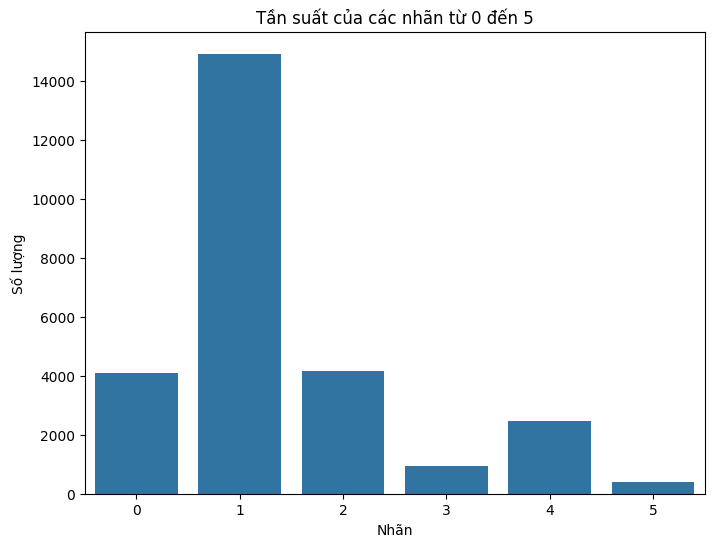

In [21]:
# Trực quan hóa tần suất nhãn
plt.figure(figsize=(8, 6))
sns.countplot(x=Y_data)  # Y_data là danh sách nhãn từ 0 đến 5
plt.title("Tần suất của các nhãn từ 0 đến 5")
plt.xlabel("Nhãn")
plt.ylabel("Số lượng")
plt.show()

In [22]:
# Kết hợp tất cả văn bản trong dữ liệu để tạo word cloud
text_data = ' '.join(X_data)

# Tạo WordCloud
for label in data['label'].unique():
    text = ' '.join(data[data['label'] == label]['old_data'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Vẽ WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Sentiment Class {label}')
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

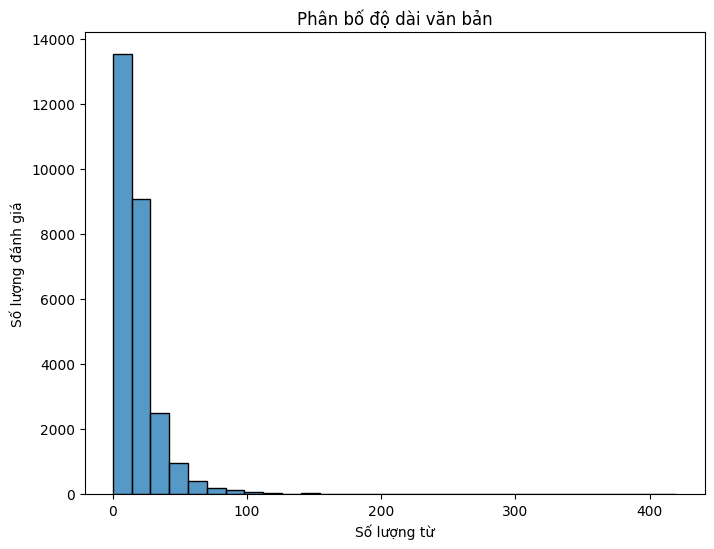

In [23]:
# Tính độ dài của từng đánh giá
text_lengths = [len(text.split()) for text in X_data]

# Vẽ biểu đồ phân bố độ dài
plt.figure(figsize=(8, 6))
sns.histplot(text_lengths, bins=30)
plt.title("Phân bố độ dài văn bản")
plt.xlabel("Số lượng từ")
plt.ylabel("Số lượng đánh giá")
plt.show()

# **Train models: Naive Bayes**

In [62]:
# Kích thước batch
BATCH_SIZE = 128
# Độ dài chuỗi tối đa
MAX_SEQ_LEN = 128
# Kích thước từ vựng
MAX_FEATURES = 5000
# Kích thước embedding
EMBEDDING_DIMS = 64
# Tốc độ học (Learning Rate)
LR = 1e-4
# Số lượng epochs
EPOCHS = 30
# Random state
RANDOM_SEED = 42
# Lưu mô hình
checkpoint_root = '/content/drive/MyDrive/Artificial-intelligence/Checkpoint-model-down/'

In [67]:
# Tạo một đối tượng LabelEncoder
label_encoder = LabelEncoder()

# Định hình lại Y_data thành 1D và khớp với LabelEncoder
y_train_encoded = label_encoder.fit_transform(Y_data.argmax(axis=1))

# Sử dụng len(X_data) để lấy số lượng mẫu trong danh sách X_data
y_train_encoded = y_train_encoded.reshape(len(X_data))

# Chia dữ liệu sau khi mã hóa các nhãn
X_train, X_test, y_train, y_test = train_test_split(X_data, y_train_encoded, test_size=0.2, random_state=RANDOM_SEED)

# Chuyển đổi văn bản thành vectơ TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Khởi tạo mô hình Naive Bayes
nb_model = MultinomialNB()

# Huấn luyện mô hình
nb_model.fit(X_train_tfidf, y_train)  # y_train bây giờ là 1D và sẽ hoạt động

MultinomialNB()

In [68]:
# Lưu mô hình
joblib.dump(nb_model, checkpoint_root + 'naivebayes_model.pkl')

['/content/drive/MyDrive/Artificial-intelligence/Checkpoint-model-down/naivebayes_model.pkl']

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.69      0.57      0.62       776
           1       0.64      0.97      0.77      3031
           2       0.47      0.08      0.14       811
           3       0.50      0.01      0.02       191
           4       0.60      0.02      0.05       493
           5       0.00      0.00      0.00        81

    accuracy                           0.64      5383
   macro avg       0.48      0.28      0.27      5383
weighted avg       0.60      0.64      0.55      5383



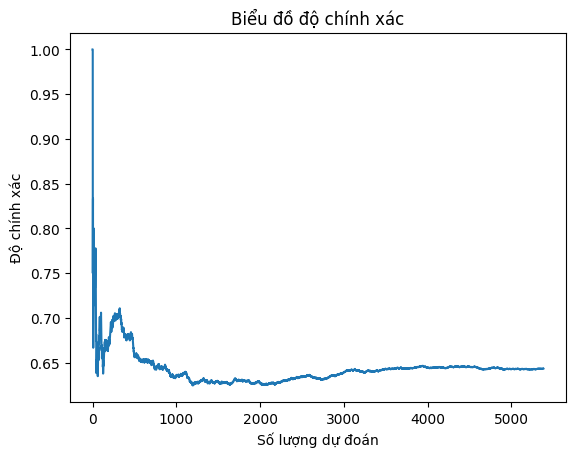

In [69]:
# Dự đoán trên tập kiểm tra và tính toán độ chính xác cho mỗi dự đoán
y_pred = nb_model.predict(X_test_tfidf)
accuracies = [accuracy_score(y_test[:i], y_pred[:i]) for i in range(1, len(y_test) + 1)]

# In ra báo cáo phân loại
print(classification_report(y_test, y_pred))

# Vẽ biểu đồ độ chính xác
plt.plot(accuracies)
plt.title("Biểu đồ độ chính xác")
plt.xlabel("Số lượng dự đoán")
plt.ylabel("Độ chính xác")
plt.show()

# **Train models: LSTM**

In [24]:
# Hàm one-hot encoding cho nhãn
def one_hot_labels(Y):
    label = np.zeros(6,)  # Tạo vector kích thước 6 cho các nhãn từ 0 đến 5
    label[Y] = 1          # Đánh dấu 1 tại vị trí tương ứng với nhãn
    return label

In [25]:
# Chuyển đổi toàn bộ nhãn trong Y_data thành dạng one-hot encoding
Y_data = np.array([one_hot_labels(y) for y in Y_data])

In [27]:
# Tải các mô hình cần thiết cho NLTK
nltk.download('punkt')

# Khai báo annotator
def annotator(sentence):
    return word_tokenize(sentence)  # Phân đoạn câu thành từ

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
def word_segmentation(sentence):
    word_sentence = annotator(sentence)  # Gọi hàm annotator
    if len(word_sentence) > 0:
        return " ".join(word_sentence)  # Chuyển danh sách từ thành chuỗi
    else:
        return ""

In [29]:
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=RANDOM_SEED)

In [30]:
# Tiền xử lý văn bản
X_train = [word_segmentation(sentence) for sentence in X_train]
X_test = [word_segmentation(sentence) for sentence in X_test]

In [31]:
# Khai báo layer text vectorization
text_vectorization_layer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES,  # Kích thước bộ từ vựng
    output_mode='int',  # Giá trị token là chỉ mục của từ trong vocab
    output_sequence_length=MAX_SEQ_LEN  # Số token tối đa trong 1 vector
)

In [32]:
# Adapt layer với dữ liệu huấn luyện
text_vectorization_layer.adapt(X_train)

In [33]:
# Chuyển đổi văn bản thành dạng số
X_train = text_vectorization_layer(X_train)
X_test = text_vectorization_layer(X_test)

In [34]:
# Padding dữ liệu đầu vào
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_SEQ_LEN)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SEQ_LEN)

In [35]:
# Xây dựng mô hình LSTM
lstm_model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_SEQ_LEN,)),
    tf.keras.layers.Embedding(input_dim=MAX_FEATURES + 1, output_dim=EMBEDDING_DIMS),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  # 6 đầu ra cho nhãn từ 0 đến 5
])

# Biên dịch mô hình
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),  # Bộ tối ưu hóa Adam
    loss='categorical_crossentropy',  # Hàm mất mát cho bài toán phân loại nhiều lớp
    metrics=['accuracy']  # Chỉ số đánh giá là độ chính xác
)

# Hiển thị thông tin mô hình
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 64)           320064    
                                                                 
 lstm (LSTM)                 (None, 128, 32)           12416     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 341430 (1.30 MB)
Trainable params: 341430 (1.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
# Hàm huấn luyện mô hình
def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size, checkpoint_filepath):
    checkpoint_filepath = checkpoint_filepath if checkpoint_filepath.endswith('.keras') else checkpoint_filepath + '.keras'

    # Callback để lưu mô hình tốt nhất trong quá trình huấn luyện
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True
    )

    # Huấn luyện mô hình
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        epochs=epochs,
        callbacks=[checkpoint]
    )

    # Vẽ biểu đồ accuracy và loss
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Epoch 1/30
169/169 [==============================] - 43s 225ms/step - loss: 1.5501 - accuracy: 0.5517 - val_loss: 1.3149 - val_accuracy: 0.5631
Epoch 2/30
169/169 [==============================] - 35s 210ms/step - loss: 1.3095 - accuracy: 0.5518 - val_loss: 1.2919 - val_accuracy: 0.5631
Epoch 3/30
169/169 [==============================] - 38s 228ms/step - loss: 1.3018 - accuracy: 0.5518 - val_loss: 1.2898 - val_accuracy: 0.5631
Epoch 4/30
169/169 [==============================] - 37s 221ms/step - loss: 1.3004 - accuracy: 0.5518 - val_loss: 1.2889 - val_accuracy: 0.5631
Epoch 5/30
169/169 [==============================] - 37s 222ms/step - loss: 1.2996 - accuracy: 0.5518 - val_loss: 1.2882 - val_accuracy: 0.5631
Epoch 6/30
169/169 [==============================] - 35s 208ms/step - loss: 1.2992 - accuracy: 0.5518 - val_loss: 1.2881 - val_accuracy: 0.5631
Epoch 7/30
169/169 [==============================] - 38s 223ms/step - loss: 1.2989 - accuracy: 0.5519 - val_loss: 1.2880 - val_ac

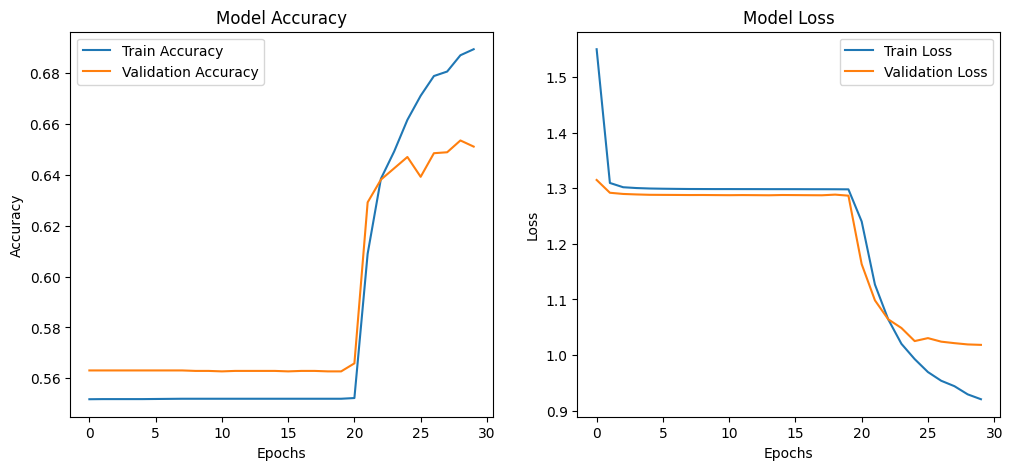

In [37]:
# Gọi hàm để huấn luyện mô hình LSTM
train_model(lstm_model, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE, checkpoint_root + 'lstm_model')

# **Train models: CNN**

In [42]:
# Xây dựng mô hình CNN
cnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_SEQ_LEN,)),
    tf.keras.layers.Embedding(input_dim=MAX_FEATURES + 1, output_dim=EMBEDDING_DIMS),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Biên dịch mô hình
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Hiển thị thông tin mô hình
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 128, 64)           320064    
                                                                 
 conv1d_2 (Conv1D)           (None, 126, 32)           6176      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 63, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 61, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1920)             

Epoch 1/30
169/169 [==============================] - 15s 80ms/step - loss: 1.4553 - accuracy: 0.5313 - val_loss: 1.2859 - val_accuracy: 0.5631
Epoch 2/30
169/169 [==============================] - 12s 72ms/step - loss: 1.2789 - accuracy: 0.5518 - val_loss: 1.2526 - val_accuracy: 0.5631
Epoch 3/30
169/169 [==============================] - 14s 86ms/step - loss: 1.2187 - accuracy: 0.5597 - val_loss: 1.1626 - val_accuracy: 0.6017
Epoch 4/30
169/169 [==============================] - 10s 61ms/step - loss: 1.0943 - accuracy: 0.6229 - val_loss: 1.0726 - val_accuracy: 0.6314
Epoch 5/30
169/169 [==============================] - 9s 53ms/step - loss: 1.0142 - accuracy: 0.6465 - val_loss: 1.0314 - val_accuracy: 0.6348
Epoch 6/30
169/169 [==============================] - 11s 63ms/step - loss: 0.9691 - accuracy: 0.6594 - val_loss: 1.0061 - val_accuracy: 0.6418
Epoch 7/30
169/169 [==============================] - 9s 50ms/step - loss: 0.9352 - accuracy: 0.6676 - val_loss: 0.9854 - val_accuracy: 0

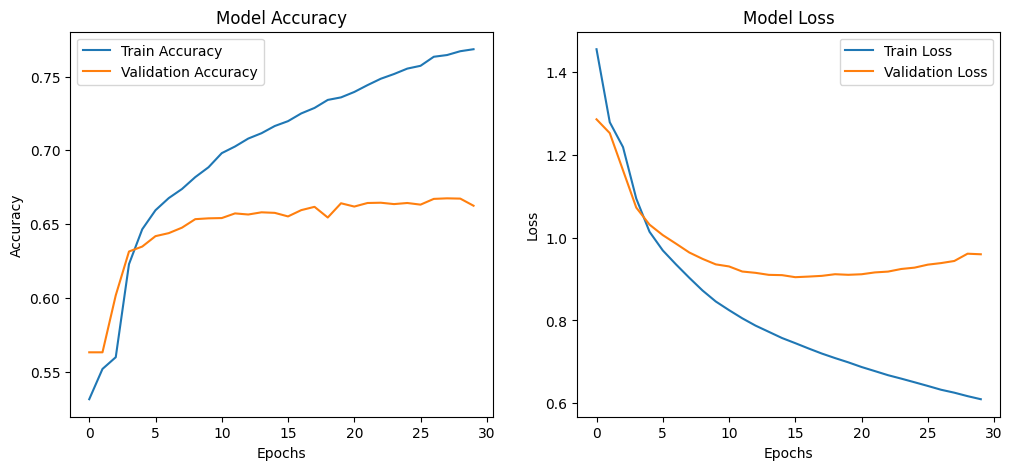

In [43]:
# Gọi hàm để huấn luyện mô hình CNN
train_model(cnn_model, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE, checkpoint_root + 'cnn_model')